In [ ]:
from google.colab import drive
import os
import shutil
import time
from tqdm import tqdm
import glob
import gc

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
import random as rn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.applications import ResNet152
from keras.models import Model

from tqdm import tqdm

# **Set Environmental Parameters**

In [ ]:
seed = 42
# The below is necessary for reproducible results of certain Python hash-based operations.
os.environ["PYTHONHASHSEED"]="0"
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(seed)
# The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
tf.random.set_seed(seed)

In [ ]:
BASE_PATH = '/content/drive/MyDrive/CIDL_Group'

FS_IMAGE_SIZE = (250, 250)
PT_IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
INTERPOLATION = "bilinear"

ENSEMBLE_MODELS_PATH = os.path.join(BASE_PATH, 'BEST_MODELS')

ENSEMBLE_MODELS_250_PATH = os.path.join(ENSEMBLE_MODELS_PATH, '250')
MODELS_TO_ENSEMBLE = [os.path.join('250', model_name) for model_name in os.listdir(ENSEMBLE_MODELS_250_PATH) if 'h5' in model_name]

ENSEMBLE_MODELS_224_PATH = os.path.join(ENSEMBLE_MODELS_PATH, '224')
MODELS_TO_ENSEMBLE += [os.path.join('224', model_name) for model_name in os.listdir(ENSEMBLE_MODELS_224_PATH) if 'h5' in model_name]

NUM_MODELS = len(MODELS_TO_ENSEMBLE)
print(MODELS_TO_ENSEMBLE)

['250/fused.h5', '250/CNN_from_scratch.h5', '224/ResNet152.h5', '224/VGG16.h5', '224/CheXNet.h5', '224/CheXNet_2.h5']


In [ ]:
DATASET_PATH = '/content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET'
TRAIN_PATH = os.path.join(DATASET_PATH, 'train')
VAL_PATH = os.path.join(DATASET_PATH, 'val')
TEST_PATH = os.path.join(DATASET_PATH, 'test')

In [ ]:
CLASSES = os.listdir(TRAIN_PATH)
NUM_CLASSES = len(CLASSES)

# **Utility Functions**

In [ ]:
def extract_labels(ds):
  ds_labels = []
  for images, labels in ds.unbatch():
    ds_labels.append(labels.numpy())
  return np.array(ds_labels)


def load_validation_set (image_size, batch_size):
  val_ds = image_dataset_from_directory(
    VAL_PATH,
    #label_mode='categorical',
    image_size = image_size,
    batch_size = BATCH_SIZE,
    shuffle=False
  )
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
  return val_ds


def load_test_set (image_size, batch_size):
  test_ds = image_dataset_from_directory(
    TEST_PATH,
    #label_mode='categorical',
    image_size = image_size,
    batch_size = BATCH_SIZE,
    shuffle=False
  )
  test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
  return test_ds


def show_evaluation(y_pred, y_true, preds):
  print("Classification report: ")
  print(metrics.classification_report(y_true, y_pred, digits = 4))
  print(f'Accuracy: {metrics.accuracy_score(y_true, y_pred)}')
  print(f'F1 per Class: {metrics.f1_score(y_true, y_pred, average=None)}')
  print(f'F1 Macro: {metrics.f1_score(y_true, y_pred, average="macro")}')
  print(f'ROC AUC: {metrics.roc_auc_score(y_true, preds, average="weighted", multi_class="ovr")}')
  metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)


def weighted_average(models_scores, weights):
  weighted_scores = []
  for i in range(len(models_scores[0])):
    weighted_score = [weight*scores[i] for weight, scores in zip(weights, models_scores)]
    weighted_average = np.sum(weighted_score, axis = 0)
    weighted_scores.append(weighted_average)
  return weighted_scores


def chromosome_to_matrix(chromosome):
  return chromosome.copy().reshape((NUM_MODELS, NUM_CLASSES))


def matrix_to_chromosome(matrix):
  return matrix.copy().reshape(NUM_MODELS*NUM_CLASSES)

# **Load Train, Validation and Test**

In [ ]:
PT_VAL_SET = load_validation_set(PT_IMAGE_SIZE, BATCH_SIZE)
PT_TEST_SET = load_test_set(PT_IMAGE_SIZE, BATCH_SIZE)

FS_VAL_SET = load_validation_set(FS_IMAGE_SIZE, BATCH_SIZE)
FS_TEST_SET = load_test_set(FS_IMAGE_SIZE, BATCH_SIZE)

Found 1292 files belonging to 4 classes.
Found 1438 files belonging to 4 classes.
Found 1292 files belonging to 4 classes.
Found 1438 files belonging to 4 classes.


In [ ]:
Y_TRUE_VAL = extract_labels(PT_VAL_SET)
Y_TRUE_TEST = extract_labels(PT_TEST_SET)

## **Load Models**

In [ ]:
models = []
for i, model_name in enumerate(MODELS_TO_ENSEMBLE):
  model = tf.keras.models.load_model(os.path.join(ENSEMBLE_MODELS_PATH, model_name))
  model._name = f'model_{i}'
  models.append(model)

In [ ]:
for model in models:
  model.summary()

Model: "model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 250, 250, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 learnable_resizer (Function  (None, 227, 227, 3)      12163     
 al)                                                             
                                                                 
 model_7 (Functional)        (None, 4)                 9199684   
                                                                 
Total params: 9,211,847
Trainable params: 9,211,719
Non-trainable params: 128
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
 Layer (type)                O

## **Compute Scores on Validation Set**

In [ ]:
VAL_SCORES = []
for i, model_name in enumerate(MODELS_TO_ENSEMBLE):
  if '250' in model_name:
    VAL_SCORES.append(models[i].predict(FS_VAL_SET, verbose=1))
  elif '224' in model_name:
    VAL_SCORES.append(models[i].predict(PT_VAL_SET, verbose=1))

41/41 [==============================] - 10s 209ms/step


In [ ]:
len(VAL_SCORES), len(VAL_SCORES[0]), VAL_SCORES[0][0], VAL_SCORES[1][0]

(6,
 1292,
 array([0.41692412, 0.11764506, 0.44439965, 0.02103115], dtype=float32),
 array([0.12503526, 0.05443755, 0.7624991 , 0.05802809], dtype=float32))

## **Compute Scores on Test Set**

In [ ]:
TEST_SCORES = []
for i, model_name in enumerate(MODELS_TO_ENSEMBLE):
  if '250' in model_name:
    TEST_SCORES.append(models[i].predict(FS_TEST_SET, verbose=1))
  elif '224' in model_name:
    TEST_SCORES.append(models[i].predict(PT_TEST_SET, verbose=1))

45/45 [==============================] - 9s 209ms/step


In [ ]:
len(TEST_SCORES), len(TEST_SCORES[0]), TEST_SCORES[0][0], TEST_SCORES[1][0]

(6,
 1438,
 array([0.27829352, 0.01685865, 0.08650606, 0.61834174], dtype=float32),
 array([0.37429538, 0.07074363, 0.26856798, 0.286393  ], dtype=float32))

# **Average Voting**

## **Validation**

In [ ]:
weights = [1/NUM_MODELS for _ in range(NUM_MODELS)]

non_weighted_scores = weighted_average(VAL_SCORES, weights)
print(len(non_weighted_scores), non_weighted_scores[0])

1292 [0.32963392 0.04767498 0.53889483 0.08379628]


In [ ]:
ensemble_predictions = np.argmax(non_weighted_scores, axis=1)
print(ensemble_predictions.shape, ensemble_predictions[:10])

(1292,) [2 0 0 0 3 2 1 2 0 0]


Classification report: 
              precision    recall  f1-score   support

           0     0.6822    0.5052    0.5805       289
           1     0.7289    0.7032    0.7158       283
           2     0.6406    0.7972    0.7104       360
           3     0.7423    0.7361    0.7392       360

    accuracy                         0.6943      1292
   macro avg     0.6985    0.6854    0.6865      1292
weighted avg     0.6976    0.6943    0.6906      1292

Accuracy: 0.6942724458204335
F1 per Class: [0.5805169  0.71582734 0.71039604 0.73919107]
F1 Macro: 0.6864828375652285
ROC AUC: 0.8825515156746058


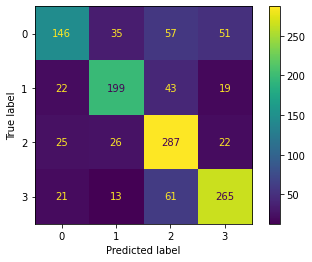

In [ ]:
show_evaluation(ensemble_predictions, Y_TRUE_VAL, non_weighted_scores)

## **Test**

In [ ]:
weights = [1/NUM_MODELS for _ in range(NUM_MODELS)]

non_weighted_scores = weighted_average(TEST_SCORES, weights)
print(len(non_weighted_scores), non_weighted_scores[0])

1438 [0.48564586 0.10007184 0.1574788  0.2568035 ]


In [ ]:
ensemble_predictions = np.argmax(non_weighted_scores, axis=1)
print(ensemble_predictions.shape, ensemble_predictions[:10])

(1438,) [0 0 2 2 0 3 3 0 0 0]


Classification report: 
              precision    recall  f1-score   support

           0     0.6890    0.5401    0.6055       324
           1     0.7661    0.7197    0.7422       314
           2     0.6449    0.7900    0.7101       400
           3     0.7268    0.7250    0.7259       400

    accuracy                         0.7003      1438
   macro avg     0.7067    0.6937    0.6959      1438
weighted avg     0.7041    0.7003    0.6980      1438

Accuracy: 0.700278164116829
F1 per Class: [0.60553633 0.74220033 0.71011236 0.72590738]
F1 Macro: 0.6959391010920013
ROC AUC: 0.8945396511836635


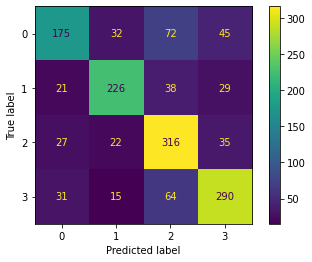

In [ ]:
show_evaluation(ensemble_predictions, Y_TRUE_TEST, non_weighted_scores)

# **Genetic Algorithm**

In [ ]:
CHROMOSOME_SIZE = NUM_MODELS
CROSSOVER_GENES_PERCENTAGE = 0.5
ELITISM_PERCENTAGE = 0.02

In [ ]:
def initialize_chromosome_population(population_size):
  # Random Initialization
  population = np.random.random((population_size, CHROMOSOME_SIZE))
  ch_sum = np.sum(population, axis=1)
  population = population/ch_sum.reshape((len(ch_sum), 1))
  return population

## **Fitness Functions**

In [ ]:
def f1_macro_measure(weights, y_true, scores):
  weighted_scores = weighted_average(scores, weights)
  y_pred = np.argmax(weighted_scores, axis=1)
  return metrics.f1_score(y_true, y_pred, average="macro")


def accuracy_measure(weights, y_true, scores):
  weighted_scores = weighted_average(scores, weights)
  y_pred = np.argmax(weighted_scores, axis=1)
  return metrics.accuracy_score(y_true, y_pred)


def roc_auc_measure(weights, y_true, scores):
  weighted_scores = weighted_average(scores, weights)
  return metrics.roc_auc_score(y_true, weighted_scores, average="weighted", multi_class="ovr")

In [ ]:
def fitness(chromosome, func='auc'):
  fitness_func = None
  if func == 'auc':
    fitness_func = roc_auc_measure
  elif func == 'f1':
    fitness_func = f1_macro_measure
  elif func == 'acc':
    fitness_func = accuracy_measure
  return fitness_func(chromosome, Y_TRUE_VAL, VAL_SCORES)

## **Selection for Recombination**

In [ ]:
def tournament_selection(population, scores, k=5):
  indexes = np.random.choice(len(population), k, replace=False)
  selected_scores = scores[indexes]
  arg_best = np.argmax(selected_scores)
  return population[indexes[arg_best]]

In [ ]:
def proportional_selection(population, scores):
  scores_sum = np.sum(scores)
  proba = [score/scores_sum for score in scores]
  chosen = np.random.choice(population, 1, p=proba)
  return chosen

In [ ]:
def selection(population, scores, mode='t', k=5):
  individual = None
  if mode == 't':
    individual = tournament_selection(population, scores, k)
  elif mode == 'p':
    individual = proportional_selection(population, scores)
  return individual

## **Crossover**

In [ ]:
def average_crossover(parent_1, parent_2):
  offspring_1, offspring_2 = parent_1.copy(), parent_2.copy()
  num_genes = round(CHROMOSOME_SIZE*CROSSOVER_GENES_PERCENTAGE)
  indexes = np.random.choice(len(parent_1), num_genes, replace=False)
  for i in indexes:
    average = (parent_1[i] + parent_2[i])/2
    offspring_1[i] = average
    offspring_2[i] = average

  offsprings = np.array([offspring_1, offspring_2])
  ch_sum = np.sum(offsprings, axis=1)
  # normalize
  offsprings = offsprings/ch_sum.reshape((len(ch_sum), 1))
  return offsprings

## **Mutation**

In [ ]:
def one_position_mutation(chromosome):
  index = np.random.choice(len(chromosome), 1)
  chromosome[index] = np.random.rand(1)
  return chromosome/np.sum(chromosome)

## **Elitism**

In [ ]:
def get_elite_individulas(population, scores):
  sorted_population = population[np.argsort(scores)[::-1]]
  num_elite = round(len(population)*ELITISM_PERCENTAGE)
  num_elite = 1 if num_elite == 0 else num_elite
  return sorted_population[0:num_elite]

## **GA**

In [ ]:
def genetic_algorithm(num_models, pop_size, num_gen, p_crossover=0.1, p_mutation=0.01, fit_func='auc', sel_mode='t', sel_k=5, init_best_w=None, verbose=1):
  
  # Initialize population
  population = initialize_chromosome_population(pop_size)

  # keep track of best solution
  random_indexes = np.random.choice(pop_size, 1)
  random_individual = population[random_indexes][0]
  if init_best_w is not None:
    population = np.append(population, init_best_w.reshape((1, init_best_w.shape[0])), axis=0)
    best_chromosome, best_fitness = init_best_w, fitness(init_best_w, func=fit_func)
  else:
    best_chromosome, best_fitness = random_individual, fitness(random_individual, func=fit_func)
  print(f'> Initizlization: {best_chromosome if verbose == 1 else []} = {best_fitness}')

  for generation in tqdm(range(num_gen)):
    # evaluate all candidates in the population
    scores = np.array([fitness(x, func=fit_func) for x in population])

    # check for new best solution
    gen_best_index = np.argmax(scores)
    if scores[gen_best_index] > best_fitness:
      best_chromosome, best_fitness = population[gen_best_index], scores[gen_best_index]
      print(f'> Generation {generation}: new best {best_chromosome if verbose == 1 else []} = {best_fitness}')
    
    # select individuals for recombination
    P1 = np.array([selection(population, scores, mode=sel_mode, k=sel_k) for _ in population])

    # generate mating pool
    MP = np.array([x for x in P1 if np.random.rand(1) < p_crossover])

    # create the next generation
    P3 = []
    for _ in range(0, pop_size, 2):
      # random parent selection
      i1 = np.random.choice(MP.shape[0], 1)
      p1 = MP[i1][0]
      while True:
        i2 = np.random.choice(MP.shape[0], 1)
        if i2 == i1:
          continue
        p2 = MP[i2][0]
        break
      
      # crossover
      offsprings = average_crossover(p1, p2)

      for offspring in offsprings:
        if np.random.rand(1) < p_mutation:
          # mutation
          offspring = one_position_mutation(offspring)

        # store for next generation
        P3.append(offspring)
    P3 = np.array(P3)

    # mantain elite individual
    elite = get_elite_individulas(population, scores)

    # replace population
    population = np.concatenate((P3, elite))
  return [best_chromosome, best_fitness]

In [ ]:
best_fitness = -1
for i in range(10):
  print("Iteration ", i)
  individual, fit = genetic_algorithm(NUM_MODELS, pop_size=100, num_gen=15, p_crossover=0.4, p_mutation=0.005, fit_func='acc')
  if fit > best_fitness:
    best_fitness = fit
    best_weights = individual
  print("------------")

Iteration  0
> Initizlization: [0.10916038 0.12997132 0.22426624 0.09197347 0.22896511 0.21566349] = 0.7120743034055728


  7%|▋         | 1/15 [00:04<01:00,  4.33s/it]

> Generation 0: new best [0.11514173 0.03984727 0.08253007 0.15464589 0.29618431 0.31165072] = 0.7198142414860681


 13%|█▎        | 2/15 [00:08<00:55,  4.30s/it]

> Generation 1: new best [0.18503711 0.04021467 0.08329102 0.12700753 0.2989152  0.26553447] = 0.7252321981424149


 20%|██        | 3/15 [00:12<00:51,  4.29s/it]

> Generation 2: new best [0.14995879 0.05024727 0.12661665 0.13668566 0.29757375 0.23891788] = 0.7267801857585139


 27%|██▋       | 4/15 [00:17<00:46,  4.23s/it]

> Generation 3: new best [0.14650354 0.03788098 0.14962585 0.1306351  0.27438767 0.26096687] = 0.7275541795665634


 33%|███▎      | 5/15 [00:21<00:42,  4.20s/it]

> Generation 4: new best [0.15687446 0.04426525 0.12374721 0.13358802 0.29083    0.25069505] = 0.7291021671826625


 40%|████      | 6/15 [00:25<00:37,  4.21s/it]

> Generation 5: new best [0.16710191 0.03940153 0.13005712 0.13328424 0.26986561 0.26028959] = 0.7298761609907121


100%|██████████| 15/15 [01:02<00:00,  4.19s/it]


------------
Iteration  1
> Initizlization: [0.20229797 0.24941697 0.02263585 0.19631699 0.11489108 0.21444114] = 0.6973684210526315


  7%|▋         | 1/15 [00:04<01:00,  4.29s/it]

> Generation 0: new best [0.22107091 0.0282059  0.13069312 0.08744794 0.30361152 0.2289706 ] = 0.7229102167182663


 13%|█▎        | 2/15 [00:08<00:55,  4.23s/it]

> Generation 1: new best [0.17938036 0.03190851 0.14784929 0.09892729 0.34465308 0.19728147] = 0.7244582043343654


 20%|██        | 3/15 [00:12<00:50,  4.20s/it]

> Generation 2: new best [0.17107745 0.02768524 0.1389177  0.12870961 0.30250911 0.2311009 ] = 0.728328173374613


 33%|███▎      | 5/15 [00:20<00:41,  4.15s/it]

> Generation 4: new best [0.16695398 0.02978824 0.13159212 0.13902287 0.29840646 0.23423634] = 0.7291021671826625


 40%|████      | 6/15 [00:25<00:37,  4.16s/it]

> Generation 5: new best [0.16559202 0.03685415 0.13249855 0.12983456 0.30937454 0.22584618] = 0.7298761609907121


100%|██████████| 15/15 [01:02<00:00,  4.19s/it]


------------
Iteration  2
> Initizlization: [0.29065974 0.23891992 0.02230319 0.22534139 0.07956116 0.14321459] = 0.6904024767801857


  7%|▋         | 1/15 [00:04<00:57,  4.11s/it]

> Generation 0: new best [0.16117472 0.0694608  0.04170648 0.20012436 0.27730432 0.25022932] = 0.7190402476780186


 13%|█▎        | 2/15 [00:08<00:54,  4.17s/it]

> Generation 1: new best [0.16784734 0.06166098 0.06678191 0.13109332 0.35031099 0.22230546] = 0.7229102167182663


 20%|██        | 3/15 [00:12<00:50,  4.19s/it]

> Generation 2: new best [0.16957283 0.04839193 0.11637966 0.13244098 0.30862382 0.22459079] = 0.7275541795665634


 33%|███▎      | 5/15 [00:20<00:41,  4.14s/it]

> Generation 4: new best [0.15300128 0.05407057 0.114358   0.12947819 0.37084834 0.17824361] = 0.728328173374613


 40%|████      | 6/15 [00:25<00:37,  4.18s/it]

> Generation 5: new best [0.16693135 0.04877192 0.12043424 0.13348095 0.34346601 0.18691554] = 0.7291021671826625


 87%|████████▋ | 13/15 [00:53<00:08,  4.13s/it]

> Generation 12: new best [0.16196249 0.04905051 0.12098763 0.1335042  0.34274218 0.19175298] = 0.7298761609907121


100%|██████████| 15/15 [01:02<00:00,  4.14s/it]


------------
Iteration  3
> Initizlization: [0.20749843 0.22259049 0.15809309 0.16198518 0.11819343 0.13163938] = 0.6942724458204335


  7%|▋         | 1/15 [00:04<00:57,  4.10s/it]

> Generation 0: new best [0.13189225 0.01489686 0.02753689 0.28010296 0.2975591  0.24801194] = 0.7229102167182663


 27%|██▋       | 4/15 [00:16<00:45,  4.16s/it]

> Generation 3: new best [0.17315709 0.04240303 0.09639916 0.15572064 0.30288674 0.22943335] = 0.7252321981424149


 33%|███▎      | 5/15 [00:20<00:42,  4.24s/it]

> Generation 4: new best [0.15230863 0.04245035 0.10154538 0.1707815  0.30322475 0.22968939] = 0.7260061919504643


 47%|████▋     | 7/15 [00:29<00:33,  4.22s/it]

> Generation 6: new best [0.13969903 0.05706554 0.1095023  0.14794439 0.26654744 0.27924132] = 0.7267801857585139


 67%|██████▋   | 10/15 [00:42<00:21,  4.24s/it]

> Generation 9: new best [0.15446096 0.05103814 0.10913346 0.1518355  0.27246762 0.26106431] = 0.7275541795665634


 80%|████████  | 12/15 [00:50<00:12,  4.28s/it]

> Generation 11: new best [0.1544998  0.05372283 0.11061301 0.14860614 0.28105814 0.25150009] = 0.728328173374613


100%|██████████| 15/15 [01:03<00:00,  4.21s/it]


------------
Iteration  4
> Initizlization: [0.10314947 0.19364807 0.24654231 0.25845388 0.03529356 0.16291271] = 0.695046439628483


  7%|▋         | 1/15 [00:04<00:56,  4.06s/it]

> Generation 0: new best [0.14209533 0.08041946 0.06899995 0.16365533 0.27624281 0.26858712] = 0.7213622291021672


 27%|██▋       | 4/15 [00:17<00:47,  4.29s/it]

> Generation 3: new best [0.07129621 0.11374435 0.16168633 0.14658984 0.239062   0.26762126] = 0.7236842105263158


 40%|████      | 6/15 [00:25<00:38,  4.27s/it]

> Generation 5: new best [0.11296272 0.05912916 0.1428686  0.13344455 0.29688655 0.25470841] = 0.7260061919504643


 47%|████▋     | 7/15 [00:29<00:33,  4.24s/it]

> Generation 6: new best [0.13418153 0.05540152 0.14416895 0.13026883 0.27895248 0.25702669] = 0.728328173374613


100%|██████████| 15/15 [01:02<00:00,  4.18s/it]


------------
Iteration  5
> Initizlization: [0.08492853 0.234767   0.33398391 0.0366834  0.02582003 0.28381714] = 0.6989164086687306


  7%|▋         | 1/15 [00:03<00:55,  3.99s/it]

> Generation 0: new best [0.03503036 0.0347638  0.24527357 0.17700173 0.23942524 0.2685053 ] = 0.7198142414860681


 13%|█▎        | 2/15 [00:08<00:52,  4.07s/it]

> Generation 1: new best [0.13278614 0.00156092 0.11293002 0.1921759  0.27055642 0.28999061] = 0.7221362229102167


 20%|██        | 3/15 [00:12<00:48,  4.06s/it]

> Generation 2: new best [0.13210336 0.02382087 0.11234934 0.16262625 0.28060067 0.2884995 ] = 0.7260061919504643


 27%|██▋       | 4/15 [00:16<00:44,  4.08s/it]

> Generation 3: new best [0.15643386 0.0507713  0.12334062 0.12167365 0.28884177 0.25893879] = 0.7267801857585139


 33%|███▎      | 5/15 [00:20<00:40,  4.05s/it]

> Generation 4: new best [0.15448518 0.04856632 0.12180418 0.143088   0.27634309 0.25571322] = 0.728328173374613


100%|██████████| 15/15 [01:00<00:00,  4.06s/it]


------------
Iteration  6
> Initizlization: [0.164529   0.06397559 0.1251564  0.17403186 0.36584179 0.10646536] = 0.7151702786377709


  7%|▋         | 1/15 [00:04<00:58,  4.16s/it]

> Generation 0: new best [0.01470327 0.10626352 0.14576243 0.20812578 0.25900677 0.26613823] = 0.7190402476780186


 13%|█▎        | 2/15 [00:08<00:54,  4.20s/it]

> Generation 1: new best [0.19630915 0.01259019 0.09772072 0.13905432 0.30536572 0.2489599 ] = 0.7229102167182663


 20%|██        | 3/15 [00:12<00:49,  4.15s/it]

> Generation 2: new best [0.15280244 0.05013781 0.12285639 0.12603848 0.22175615 0.32640874] = 0.7267801857585139


 33%|███▎      | 5/15 [00:20<00:41,  4.12s/it]

> Generation 4: new best [0.14763166 0.03197832 0.12740414 0.13843019 0.29348973 0.26106594] = 0.7275541795665634


 40%|████      | 6/15 [00:24<00:36,  4.09s/it]

> Generation 5: new best [0.15492014 0.03926537 0.1274336  0.1384622  0.27879238 0.26112631] = 0.728328173374613


 47%|████▋     | 7/15 [00:28<00:32,  4.07s/it]

> Generation 6: new best [0.16763384 0.04478807 0.12232727 0.13299955 0.25416675 0.27808453] = 0.7291021671826625


100%|██████████| 15/15 [01:02<00:00,  4.14s/it]


------------
Iteration  7
> Initizlization: [0.37884447 0.2109114  0.00717687 0.09209138 0.30780165 0.00317423] = 0.6958204334365325


  7%|▋         | 1/15 [00:04<00:56,  4.06s/it]

> Generation 0: new best [0.03625672 0.12299093 0.22195146 0.16904482 0.24582653 0.20392955] = 0.7167182662538699


 13%|█▎        | 2/15 [00:08<00:53,  4.15s/it]

> Generation 1: new best [0.07299625 0.07144045 0.13827683 0.19398024 0.22799909 0.29530714] = 0.7190402476780186


 20%|██        | 3/15 [00:12<00:49,  4.15s/it]

> Generation 2: new best [0.15793947 0.0864958  0.06666415 0.13788903 0.21590987 0.33510168] = 0.7252321981424149


 40%|████      | 6/15 [00:25<00:37,  4.21s/it]

> Generation 5: new best [0.12428955 0.06274425 0.14544768 0.13396997 0.26252088 0.27102768] = 0.7260061919504643


 53%|█████▎    | 8/15 [00:33<00:29,  4.21s/it]

> Generation 7: new best [0.12668989 0.06826072 0.12936456 0.12738133 0.24328552 0.30501798] = 0.7267801857585139


 67%|██████▋   | 10/15 [00:42<00:21,  4.24s/it]

> Generation 9: new best [0.12917712 0.0633341  0.13172894 0.12508348 0.23147537 0.31920099] = 0.7275541795665634


100%|██████████| 15/15 [01:02<00:00,  4.17s/it]


------------
Iteration  8
> Initizlization: [0.08564226 0.1967125  0.20053291 0.20508284 0.02074284 0.29128665] = 0.6958204334365325


  7%|▋         | 1/15 [00:04<00:57,  4.13s/it]

> Generation 0: new best [0.05861756 0.20335628 0.07978667 0.1883946  0.2566052  0.21323969] = 0.7190402476780186


 20%|██        | 3/15 [00:12<00:48,  4.07s/it]

> Generation 2: new best [0.09761685 0.08627293 0.15474456 0.15852807 0.27849351 0.22434408] = 0.7198142414860681


 27%|██▋       | 4/15 [00:16<00:44,  4.05s/it]

> Generation 3: new best [0.10032608 0.09128314 0.13188293 0.1704663  0.31201659 0.19402495] = 0.7205882352941176


 33%|███▎      | 5/15 [00:20<00:40,  4.09s/it]

> Generation 4: new best [0.08692232 0.07363856 0.14913891 0.16267791 0.29424326 0.23337904] = 0.7229102167182663


100%|██████████| 15/15 [01:01<00:00,  4.10s/it]


------------
Iteration  9
> Initizlization: [0.22312626 0.22762949 0.08269028 0.18474899 0.16715836 0.11464662] = 0.6981424148606811


  7%|▋         | 1/15 [00:04<00:57,  4.09s/it]

> Generation 0: new best [0.05463423 0.02487763 0.14071752 0.20433503 0.28418799 0.2912476 ] = 0.718266253869969


 13%|█▎        | 2/15 [00:08<00:53,  4.12s/it]

> Generation 1: new best [0.12113721 0.10177061 0.13389863 0.14108206 0.20586802 0.29624348] = 0.7205882352941176


 20%|██        | 3/15 [00:12<00:49,  4.16s/it]

> Generation 2: new best [0.1100652  0.0903058  0.12344116 0.14476739 0.20577789 0.32564256] = 0.7229102167182663


 27%|██▋       | 4/15 [00:16<00:45,  4.12s/it]

> Generation 3: new best [0.12312403 0.07571732 0.12548522 0.1218436  0.29505047 0.25877935] = 0.7244582043343654


 40%|████      | 6/15 [00:24<00:36,  4.09s/it]

> Generation 5: new best [0.12993999 0.03849794 0.12513449 0.15622468 0.28236033 0.26784257] = 0.7260061919504643


 47%|████▋     | 7/15 [00:28<00:32,  4.07s/it]

> Generation 6: new best [0.129605   0.04369939 0.1186124  0.15270936 0.2986087  0.25676515] = 0.7267801857585139


100%|██████████| 15/15 [01:01<00:00,  4.11s/it]

------------


In [ ]:
print(best_weights)
print(best_fitness)

[0.16710191 0.03940153 0.13005712 0.13328424 0.26986561 0.26028959]
0.7298761609907121


# **Optimal Weighted Average Voting**

## **Validation**

Classification report: 
              precision    recall  f1-score   support

           0     0.7008    0.6159    0.6556       289
           1     0.7621    0.7244    0.7428       283
           2     0.6919    0.8111    0.7468       360
           3     0.7723    0.7444    0.7581       360

    accuracy                         0.7299      1292
   macro avg     0.7318    0.7240    0.7258      1292
weighted avg     0.7317    0.7299    0.7287      1292

Accuracy: 0.7298761609907121
F1 per Class: [0.65561694 0.74275362 0.74680307 0.75813296]
F1 Macro: 0.7258266478261582
ROC AUC: 0.8940335796561641


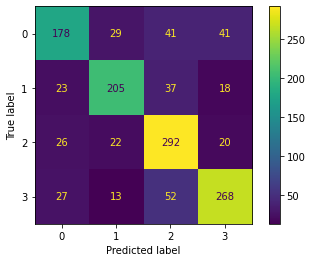

In [ ]:
ensemble_scores = weighted_average(VAL_SCORES, best_weights)
ensemble_predictions = np.argmax(ensemble_scores, axis=1)
show_evaluation(ensemble_predictions, Y_TRUE_VAL, ensemble_scores)

## **Test**

Classification report: 
              precision    recall  f1-score   support

           0     0.7230    0.6204    0.6678       324
           1     0.7649    0.7357    0.7500       314
           2     0.6852    0.8000    0.7382       400
           3     0.7596    0.7425    0.7509       400

    accuracy                         0.7295      1438
   macro avg     0.7332    0.7246    0.7267      1438
weighted avg     0.7318    0.7295    0.7284      1438

Accuracy: 0.7294853963838664
F1 per Class: [0.66777409 0.75       0.73817762 0.75094817]
F1 Macro: 0.7267249693117201
ROC AUC: 0.9071915892709144


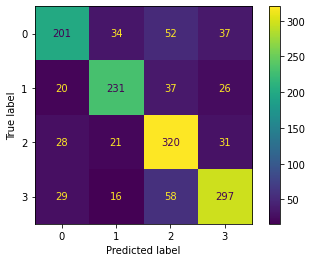

In [ ]:
ensemble_scores = weighted_average(TEST_SCORES, best_weights)
ensemble_predictions = np.argmax(ensemble_scores, axis=1)
show_evaluation(ensemble_predictions, Y_TRUE_TEST, ensemble_scores)

In [ ]:
best_fitness_f1 = -1
for i in range(10):
  print("Iteration ", i)
  individual, fit = genetic_algorithm(NUM_MODELS, pop_size=100, num_gen=15, p_crossover=0.4, p_mutation=0.005, fit_func='f1')
  if fit > best_fitness:
    best_fitness = fit
    best_weights_f1 = individual
  print("------------")

Iteration  0
> Initizlization: [0.17330592 0.13624561 0.21228481 0.04304858 0.27557436 0.15954072] = 0.7052941714732736


  7%|▋         | 1/15 [00:04<00:58,  4.18s/it]

> Generation 0: new best [0.19151197 0.0228564  0.19317534 0.10760314 0.29546681 0.18938635] = 0.7127153343365256


 13%|█▎        | 2/15 [00:08<00:54,  4.21s/it]

> Generation 1: new best [0.07502675 0.16546837 0.10907791 0.15794304 0.28079606 0.21168787] = 0.7156064142115666


 20%|██        | 3/15 [00:12<00:49,  4.16s/it]

> Generation 2: new best [0.15396185 0.02713675 0.14473207 0.12695613 0.29104828 0.25616492] = 0.7229512198718565


 33%|███▎      | 5/15 [00:23<00:51,  5.19s/it]

> Generation 4: new best [0.15671211 0.02781848 0.14253815 0.13055742 0.26865711 0.27371674] = 0.7236291097571135


 40%|████      | 6/15 [00:36<01:08,  7.63s/it]

> Generation 5: new best [0.15280061 0.05685546 0.10743026 0.13162386 0.28944598 0.26184383] = 0.7236574345611221


 47%|████▋     | 7/15 [00:46<01:08,  8.55s/it]

> Generation 6: new best [0.17074335 0.02651099 0.13332467 0.12930126 0.28420864 0.25591108] = 0.7242608884914776


 53%|█████▎    | 8/15 [00:50<00:50,  7.19s/it]

> Generation 7: new best [0.15663898 0.04871826 0.12666905 0.13400602 0.27629561 0.25767208] = 0.7249681020699783


 60%|██████    | 9/15 [00:54<00:37,  6.25s/it]

> Generation 8: new best [0.14899982 0.04505254 0.13898864 0.13175305 0.28287967 0.25232627] = 0.7250022188544744


 67%|██████▋   | 10/15 [00:59<00:28,  5.67s/it]

> Generation 9: new best [0.16125192 0.0417635  0.13074769 0.13225159 0.27880784 0.25517746] = 0.7258266478261582


100%|██████████| 15/15 [01:20<00:00,  5.36s/it]


------------
Iteration  1
> Initizlization: [0.24294201 0.01565856 0.12615055 0.07631128 0.3561032  0.18283441] = 0.7173622540503011


 13%|█▎        | 2/15 [00:08<00:54,  4.19s/it]

> Generation 1: new best [0.16241038 0.04417378 0.07062139 0.15744181 0.18341044 0.38194219] = 0.7182328991787734


 20%|██        | 3/15 [00:12<00:50,  4.20s/it]

> Generation 2: new best [0.17022148 0.04855525 0.07927384 0.12616021 0.17547759 0.40031163] = 0.7206933761333411


 27%|██▋       | 4/15 [00:16<00:45,  4.18s/it]

> Generation 3: new best [0.16874259 0.0481334  0.08495209 0.12506413 0.20485623 0.36825156] = 0.7214305241428405


 33%|███▎      | 5/15 [00:20<00:41,  4.14s/it]

> Generation 4: new best [0.18785516 0.0420225  0.09315031 0.11657877 0.19689993 0.36349334] = 0.7227240012116167


 40%|████      | 6/15 [00:25<00:37,  4.20s/it]

> Generation 5: new best [0.16371382 0.0477757  0.1271863  0.10388407 0.2243794  0.33306071] = 0.72293844470167


 47%|████▋     | 7/15 [00:29<00:33,  4.22s/it]

> Generation 6: new best [0.16897875 0.04604873 0.12258883 0.10563973 0.21626865 0.34047532] = 0.7229970079000241


 53%|█████▎    | 8/15 [00:33<00:29,  4.23s/it]

> Generation 7: new best [0.16558213 0.04848182 0.11213403 0.11367438 0.21462426 0.34550339] = 0.7236998775121293


 60%|██████    | 9/15 [00:37<00:25,  4.27s/it]

> Generation 8: new best [0.16654543 0.04515044 0.12374947 0.10594435 0.21831622 0.34029409] = 0.723800765422365


100%|██████████| 15/15 [01:04<00:00,  4.28s/it]


------------
Iteration  2
> Initizlization: [0.37454657 0.01556255 0.01731429 0.12004258 0.15470125 0.31783277] = 0.699054829438879


  7%|▋         | 1/15 [00:04<00:56,  4.04s/it]

> Generation 0: new best [0.14512213 0.08768998 0.08654785 0.16263807 0.17621417 0.34178779] = 0.7137895146098728


 13%|█▎        | 2/15 [00:08<00:53,  4.12s/it]

> Generation 1: new best [0.15787116 0.06260719 0.08762836 0.16414196 0.25331704 0.27443428] = 0.7184090634155423


 20%|██        | 3/15 [00:12<00:49,  4.14s/it]

> Generation 2: new best [0.16219289 0.04894504 0.12050556 0.14109487 0.2260542  0.30120743] = 0.7226200023046616


 33%|███▎      | 5/15 [00:20<00:42,  4.24s/it]

> Generation 4: new best [0.14352348 0.05522356 0.13244699 0.13078788 0.26300689 0.27501121] = 0.7240434461409685


 40%|████      | 6/15 [00:25<00:37,  4.22s/it]

> Generation 5: new best [0.15871719 0.04904086 0.12074149 0.14137111 0.23873449 0.29139487] = 0.7242814645354506


 60%|██████    | 9/15 [00:37<00:25,  4.28s/it]

> Generation 8: new best [0.15744903 0.04864903 0.11997816 0.14024155 0.24321914 0.29046309] = 0.7243161685594055


 73%|███████▎  | 11/15 [00:46<00:16,  4.24s/it]

> Generation 10: new best [0.14913003 0.0509236  0.12947092 0.13646603 0.25146887 0.28254054] = 0.7250022188544744


100%|██████████| 15/15 [01:03<00:00,  4.25s/it]


------------
Iteration  3
> Initizlization: [0.41886007 0.20255325 0.06112124 0.09954399 0.12004175 0.0978797 ] = 0.6716901181565115


  7%|▋         | 1/15 [00:04<01:05,  4.64s/it]

> Generation 0: new best [0.1824313  0.09752214 0.11967446 0.09656745 0.40909119 0.09471346] = 0.7131313485252255


 13%|█▎        | 2/15 [00:08<00:58,  4.47s/it]

> Generation 1: new best [0.03053559 0.07669566 0.15468055 0.20218843 0.2217491  0.31415067] = 0.7164609408747766


 20%|██        | 3/15 [00:13<00:53,  4.46s/it]

> Generation 2: new best [0.11888416 0.05395018 0.08274645 0.15195168 0.21846987 0.37399766] = 0.7193982542990957


 27%|██▋       | 4/15 [00:17<00:48,  4.40s/it]

> Generation 3: new best [0.12451138 0.05930852 0.085333   0.16604638 0.21923433 0.34556639] = 0.7201801928435971


 33%|███▎      | 5/15 [00:22<00:43,  4.38s/it]

> Generation 4: new best [0.14081128 0.05478627 0.11772513 0.13861391 0.22966127 0.31840214] = 0.7219219155896416


 40%|████      | 6/15 [00:26<00:39,  4.35s/it]

> Generation 5: new best [0.1402202  0.06034252 0.12223516 0.13143934 0.22869721 0.31706557] = 0.7234048765368816


 80%|████████  | 12/15 [00:52<00:12,  4.27s/it]

> Generation 11: new best [0.12979424 0.05441984 0.1238118  0.13009492 0.21397101 0.34790819] = 0.7238037766454932


100%|██████████| 15/15 [01:04<00:00,  4.32s/it]


------------
Iteration  4
> Initizlization: [0.19537394 0.24241684 0.1945892  0.04571506 0.04797873 0.27392622] = 0.6921667753559007


  7%|▋         | 1/15 [00:04<00:58,  4.19s/it]

> Generation 0: new best [0.23249094 0.05595021 0.09356468 0.06409787 0.18561061 0.36828569] = 0.7156849550819266


 13%|█▎        | 2/15 [00:08<00:55,  4.23s/it]

> Generation 1: new best [0.20285066 0.06486359 0.13269313 0.07430924 0.21518007 0.31010331] = 0.7171776849122656


 20%|██        | 3/15 [00:12<00:50,  4.24s/it]

> Generation 2: new best [0.15093346 0.05735512 0.09591408 0.13660114 0.16631828 0.39287792] = 0.7214363521095273


 33%|███▎      | 5/15 [00:20<00:41,  4.16s/it]

> Generation 4: new best [0.11778982 0.0724914  0.11841024 0.1352477  0.19191673 0.36414411] = 0.7218006647379631


 40%|████      | 6/15 [00:25<00:37,  4.21s/it]

> Generation 5: new best [0.15203116 0.05960657 0.09661164 0.13524506 0.16752787 0.38897771] = 0.72212049911259


 47%|████▋     | 7/15 [00:29<00:33,  4.23s/it]

> Generation 6: new best [0.11527069 0.07049355 0.13403661 0.12727377 0.18626904 0.36665634] = 0.7231819560283798


 60%|██████    | 9/15 [00:37<00:25,  4.19s/it]

> Generation 8: new best [0.12991485 0.06265911 0.13766728 0.12553609 0.18915284 0.35506983] = 0.7236943592793956


 67%|██████▋   | 10/15 [00:42<00:21,  4.23s/it]

> Generation 9: new best [0.11701536 0.06594112 0.13632748 0.1315393  0.18990533 0.35927141] = 0.7238506613200486


100%|██████████| 15/15 [01:03<00:00,  4.22s/it]


------------
Iteration  5
> Initizlization: [0.24434516 0.18052499 0.07450065 0.31318792 0.12108851 0.06635277] = 0.6840969695762132


  7%|▋         | 1/15 [00:04<00:57,  4.14s/it]

> Generation 0: new best [0.18790387 0.00755545 0.04937922 0.30630638 0.30898445 0.13987064] = 0.7116618966907453


 13%|█▎        | 2/15 [00:08<00:54,  4.19s/it]

> Generation 1: new best [0.13452105 0.04014813 0.20272949 0.08352476 0.26955425 0.26952231] = 0.7171211335995715


 20%|██        | 3/15 [00:12<00:50,  4.23s/it]

> Generation 2: new best [0.08111424 0.00923832 0.18099861 0.18508824 0.19356253 0.34999806] = 0.7178952140316843


 33%|███▎      | 5/15 [00:21<00:42,  4.29s/it]

> Generation 4: new best [0.09022474 0.10954432 0.13215794 0.15195787 0.24156869 0.27454645] = 0.7194068383822592


 47%|████▋     | 7/15 [00:29<00:34,  4.30s/it]

> Generation 6: new best [0.08989308 0.11331342 0.13923275 0.14334283 0.24068069 0.27353723] = 0.7201111824398709


 60%|██████    | 9/15 [00:38<00:25,  4.28s/it]

> Generation 8: new best [0.09017077 0.10732126 0.13596119 0.15138214 0.2411323  0.27403234] = 0.7201424736355027


100%|██████████| 15/15 [01:04<00:00,  4.31s/it]


------------
Iteration  6
> Initizlization: [0.00834429 0.36029744 0.35784069 0.06930418 0.16940677 0.03480664] = 0.6706435601179275


  7%|▋         | 1/15 [00:04<00:59,  4.22s/it]

> Generation 0: new best [0.10384362 0.04916772 0.06329432 0.07943685 0.37375722 0.33050027] = 0.7141668918534532


 13%|█▎        | 2/15 [00:08<00:55,  4.30s/it]

> Generation 1: new best [0.1568579  0.07903537 0.17049131 0.11177417 0.28350602 0.19833523] = 0.7159468744491653


 20%|██        | 3/15 [00:12<00:51,  4.26s/it]

> Generation 2: new best [0.13773556 0.03271084 0.10681844 0.15770973 0.30307101 0.26195442] = 0.7213763455998764


 27%|██▋       | 4/15 [00:17<00:46,  4.26s/it]

> Generation 3: new best [0.14270359 0.05401542 0.12636067 0.13045088 0.1694467  0.37702273] = 0.722787274014193


 33%|███▎      | 5/15 [00:21<00:42,  4.28s/it]

> Generation 4: new best [0.16915941 0.03829589 0.12825772 0.12459929 0.28823985 0.25144783] = 0.7237538422326497


 40%|████      | 6/15 [00:25<00:39,  4.37s/it]

> Generation 5: new best [0.16841008 0.04569335 0.12625299 0.13033972 0.16930231 0.36000156] = 0.7243311876170431


 47%|████▋     | 7/15 [00:30<00:35,  4.38s/it]

> Generation 6: new best [0.17241259 0.04036762 0.13072429 0.12794217 0.27226979 0.25628353] = 0.7245503471839647


 60%|██████    | 9/15 [00:38<00:26,  4.36s/it]

> Generation 8: new best [0.16894462 0.04155459 0.12822214 0.13073279 0.26672654 0.26381932] = 0.7252179939289453


 73%|███████▎  | 11/15 [00:47<00:17,  4.31s/it]

> Generation 10: new best [0.17022754 0.04296435 0.1233716  0.12965001 0.26737609 0.26641041] = 0.7253183873466837


100%|██████████| 15/15 [01:04<00:00,  4.33s/it]


------------
Iteration  7
> Initizlization: [0.25210632 0.14738666 0.11276761 0.17909823 0.16146727 0.14717391] = 0.6927771434643519


  7%|▋         | 1/15 [00:04<01:00,  4.33s/it]

> Generation 0: new best [0.08755301 0.09180129 0.16261421 0.14473655 0.36869297 0.14460195] = 0.717908368594981


 13%|█▎        | 2/15 [00:08<00:56,  4.37s/it]

> Generation 1: new best [0.18265086 0.00830591 0.07985253 0.1938569  0.27745333 0.25788047] = 0.718496867404326


 20%|██        | 3/15 [00:13<00:52,  4.33s/it]

> Generation 2: new best [0.13050533 0.04237363 0.12216506 0.13882319 0.35362962 0.21250316] = 0.7223018278530325


 33%|███▎      | 5/15 [00:21<00:43,  4.34s/it]

> Generation 4: new best [0.1303198  0.03463324 0.11333156 0.16233528 0.30832132 0.2510588 ] = 0.7231067450799764


 40%|████      | 6/15 [00:26<00:39,  4.39s/it]

> Generation 5: new best [0.15612689 0.05257414 0.10534735 0.14304794 0.29042009 0.25248358] = 0.7234578521489383


100%|██████████| 15/15 [01:05<00:00,  4.34s/it]


------------
Iteration  8
> Initizlization: [0.22741192 0.29108888 0.07277959 0.3109657  0.06067815 0.03707575] = 0.668864431861699


  7%|▋         | 1/15 [00:04<00:59,  4.28s/it]

> Generation 0: new best [0.111955   0.02942849 0.18078686 0.14047274 0.24328589 0.29407102] = 0.7179273693903891


 13%|█▎        | 2/15 [00:08<00:57,  4.44s/it]

> Generation 1: new best [0.18630267 0.0193428  0.01787423 0.19927081 0.30229595 0.27491354] = 0.7179390960565295


 20%|██        | 3/15 [00:13<00:52,  4.37s/it]

> Generation 2: new best [0.17148834 0.04487506 0.10537689 0.12561427 0.27897928 0.27366617] = 0.7229445424541205


 33%|███▎      | 5/15 [00:21<00:43,  4.35s/it]

> Generation 4: new best [0.14613885 0.03083325 0.13387126 0.14620678 0.27164829 0.27130157] = 0.7234190758921096


 40%|████      | 6/15 [00:26<00:39,  4.35s/it]

> Generation 5: new best [0.16744358 0.04488455 0.11640822 0.12265151 0.26009119 0.28852096] = 0.7236820714580956


 47%|████▋     | 7/15 [00:30<00:34,  4.36s/it]

> Generation 6: new best [0.1672521  0.04428559 0.11872769 0.13173249 0.26459111 0.27341102] = 0.7244315810347814


 53%|█████▎    | 8/15 [00:34<00:30,  4.34s/it]

> Generation 7: new best [0.15977085 0.04042957 0.1311099  0.13462666 0.266045   0.26801802] = 0.7250177664911119


 60%|██████    | 9/15 [00:39<00:26,  4.36s/it]

> Generation 8: new best [0.16333311 0.04012972 0.13013751 0.1336282  0.26295964 0.26981182] = 0.7258266478261582


100%|██████████| 15/15 [01:05<00:00,  4.37s/it]


------------
Iteration  9
> Initizlization: [0.0733235  0.23708174 0.15755572 0.29602206 0.04557301 0.19044398] = 0.682420402921925


  7%|▋         | 1/15 [00:04<01:01,  4.42s/it]

> Generation 0: new best [0.02342768 0.21069707 0.16849046 0.1075711  0.23291182 0.25690187] = 0.717112745213557


 20%|██        | 3/15 [00:13<00:52,  4.34s/it]

> Generation 2: new best [0.18443126 0.01462853 0.1367786  0.1362013  0.1655289  0.36243142] = 0.7203805654646299


 27%|██▋       | 4/15 [00:17<00:47,  4.31s/it]

> Generation 3: new best [0.1543089  0.01528555 0.12323253 0.15549986 0.17296347 0.37870968] = 0.7210896970735409


 33%|███▎      | 5/15 [00:21<00:43,  4.34s/it]

> Generation 4: new best [0.14711397 0.05284556 0.132685   0.13298139 0.29985499 0.23451909] = 0.7242269238553808


 40%|████      | 6/15 [00:26<00:39,  4.35s/it]

> Generation 5: new best [0.16389734 0.03368344 0.13278051 0.13487997 0.30007083 0.23468791] = 0.7250177664911119


 47%|████▋     | 7/15 [00:30<00:34,  4.37s/it]

> Generation 6: new best [0.17824536 0.03143664 0.12670967 0.13278351 0.19573361 0.33509121] = 0.7252179939289453


 67%|██████▋   | 10/15 [00:43<00:21,  4.37s/it]

> Generation 9: new best [0.15868243 0.0377443  0.13517663 0.13457438 0.19423455 0.33958771] = 0.7258266478261582


100%|██████████| 15/15 [01:05<00:00,  4.35s/it]

------------


In [ ]:
print(best_weights_f1)
print(best_fitness_f1)

[0.16125192, 0.0417635, 0.13074769, 0.13225159, 0.27880784, 0.25517746]
0.7258266478261582


Classification report: 
              precision    recall  f1-score   support

           0     0.7008    0.6159    0.6556       289
           1     0.7621    0.7244    0.7428       283
           2     0.6919    0.8111    0.7468       360
           3     0.7723    0.7444    0.7581       360

    accuracy                         0.7299      1292
   macro avg     0.7318    0.7240    0.7258      1292
weighted avg     0.7317    0.7299    0.7287      1292

Accuracy: 0.7298761609907121
F1 per Class: [0.65561694 0.74275362 0.74680307 0.75813296]
F1 Macro: 0.7258266478261582
ROC AUC: 0.8940455382235436


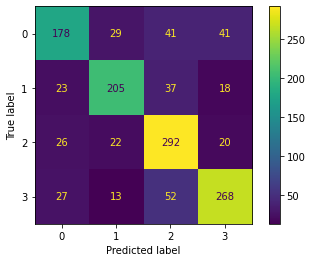

In [ ]:
ensemble_scores = weighted_average(VAL_SCORES, best_weights_f1)
ensemble_predictions = np.argmax(ensemble_scores, axis=1)
show_evaluation(ensemble_predictions, Y_TRUE_VAL, ensemble_scores)

Classification report: 
              precision    recall  f1-score   support

           0     0.7240    0.6235    0.6700       324
           1     0.7649    0.7357    0.7500       314
           2     0.6867    0.8000    0.7390       400
           3     0.7596    0.7425    0.7509       400

    accuracy                         0.7302      1438
   macro avg     0.7338    0.7254    0.7275      1438
weighted avg     0.7325    0.7302    0.7292      1438

Accuracy: 0.7301808066759388
F1 per Class: [0.66998342 0.75       0.73903002 0.75094817]
F1 Macro: 0.727490401556033
ROC AUC: 0.9072424177958913


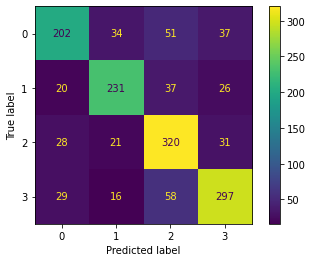

In [ ]:
ensemble_scores = weighted_average(TEST_SCORES, best_weights_f1)
ensemble_predictions = np.argmax(ensemble_scores, axis=1)
show_evaluation(ensemble_predictions, Y_TRUE_TEST, ensemble_scores)

250/fused.h5
Classification report: 
              precision    recall  f1-score   support

           0     0.5633    0.5216    0.5417       324
           1     0.7362    0.5510    0.6302       314
           2     0.6039    0.6975    0.6473       400
           3     0.6667    0.7350    0.6992       400

    accuracy                         0.6363      1438
   macro avg     0.6425    0.6263    0.6296      1438
weighted avg     0.6411    0.6363    0.6342      1438

Accuracy: 0.6363004172461753
F1 per Class: [0.54166667 0.63023679 0.64733179 0.69916766]
F1 Macro: 0.6296007262328365
ROC AUC: 0.9072424177958913


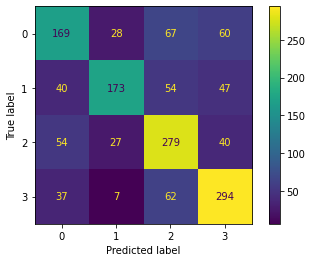

250/CNN_from_scratch.h5
Classification report: 
              precision    recall  f1-score   support

           0     0.5550    0.3426    0.4237       324
           1     0.6276    0.6815    0.6534       314
           2     0.5581    0.6600    0.6048       400
           3     0.6415    0.6800    0.6602       400

    accuracy                         0.5987      1438
   macro avg     0.5956    0.5910    0.5855      1438
weighted avg     0.5958    0.5987    0.5900      1438

Accuracy: 0.5987482614742698
F1 per Class: [0.42366412 0.65343511 0.604811   0.66019417]
F1 Macro: 0.5855261019905192
ROC AUC: 0.9072424177958913


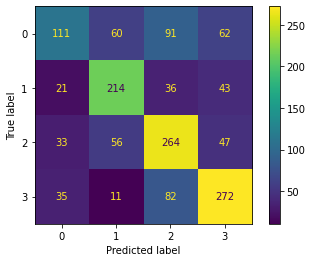

224/ResNet152.h5
Classification report: 
              precision    recall  f1-score   support

           0     0.5489    0.4506    0.4949       324
           1     0.5719    0.5828    0.5773       314
           2     0.5789    0.6325    0.6045       400
           3     0.6723    0.6975    0.6847       400

    accuracy                         0.5987      1438
   macro avg     0.5930    0.5909    0.5904      1438
weighted avg     0.5966    0.5987    0.5962      1438

Accuracy: 0.5987482614742698
F1 per Class: [0.49491525 0.57728707 0.60454002 0.68466258]
F1 Macro: 0.590351230266331
ROC AUC: 0.9072424177958913


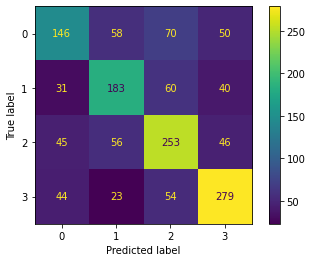

224/VGG16.h5
Classification report: 
              precision    recall  f1-score   support

           0     0.6082    0.4599    0.5237       324
           1     0.6636    0.6911    0.6771       314
           2     0.5769    0.7600    0.6559       400
           3     0.7404    0.6275    0.6793       400

    accuracy                         0.6405      1438
   macro avg     0.6473    0.6346    0.6340      1438
weighted avg     0.6483    0.6405    0.6372      1438

Accuracy: 0.6404728789986092
F1 per Class: [0.52372583 0.67706708 0.65587918 0.67929635]
F1 Macro: 0.633992111011574
ROC AUC: 0.9072424177958913


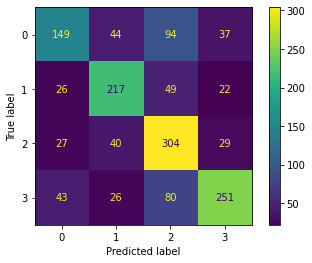

224/CheXNet.h5
Classification report: 
              precision    recall  f1-score   support

           0     0.7045    0.6327    0.6667       324
           1     0.7453    0.7548    0.7500       314
           2     0.6968    0.7700    0.7316       400
           3     0.7364    0.7125    0.7243       400

    accuracy                         0.7197      1438
   macro avg     0.7208    0.7175    0.7181      1438
weighted avg     0.7201    0.7197    0.7189      1438

Accuracy: 0.719749652294854
F1 per Class: [0.66666667 0.75       0.73159145 0.72426938]
F1 Macro: 0.7181318732450621
ROC AUC: 0.9072424177958913


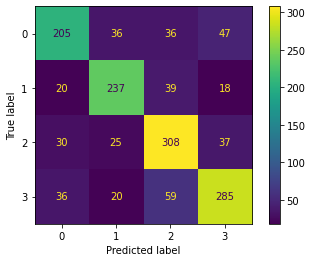

224/CheXNet_2.h5
Classification report: 
              precision    recall  f1-score   support

           0     0.6983    0.6358    0.6656       324
           1     0.7476    0.7452    0.7464       314
           2     0.6957    0.7775    0.7344       400
           3     0.7415    0.7100    0.7254       400

    accuracy                         0.7197      1438
   macro avg     0.7208    0.7171    0.7179      1438
weighted avg     0.7204    0.7197    0.7190      1438

Accuracy: 0.719749652294854
F1 per Class: [0.66558966 0.74641148 0.73435655 0.72541507]
F1 Macro: 0.7179431916944374
ROC AUC: 0.9072424177958913


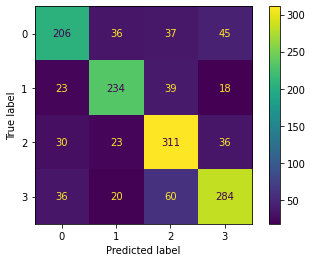

In [ ]:
for i, model_name in enumerate(MODELS_TO_ENSEMBLE):
  print(model_name)
  ensemble_predictions = np.argmax(TEST_SCORES[i], axis=1)
  show_evaluation(ensemble_predictions, Y_TRUE_TEST, ensemble_scores)
  plt.show()